In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
from datetime import datetime

import geopandas as gpd
import shapely.geometry
import rasterio
import json
import geopandas as gpd
import geopandas_osm.osm
from descartes import PolygonPatch
import h5py 
from scipy.misc import imresize
import shapely.geometry

import tensorflow as tf
import cv2
import pickle
import copy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
output_dir = "/home/ubuntu/data/TX_paired/"

geo_df = pickle.load( open( output_dir+"GeoDataFrame_fine_turked.pickled", "rb" ))
geo_df.rename(columns = {'post-storm_full':'post_resized','pre-storm_full':'pre_resized','post-storm_resized':'post_full','pre-storm_resized':'pre_full'}, inplace=True)
geo_df.set_index("tile_no")
geo_df.head(2)

,tile_no,flooded,post_resized,pre_resized,post_full,pre_full,course_mask_full,course_mask_resized,fine_mask_filename,footprint,dry_or_wet,mask_poly,tile_transform,geometry,DBScan,DBScan_gauss,bad_image,problem,verified
0,0,0.80323,0_post_resize_img,0_pre_resize_img,0_post_full_img,0_pre_full_img,0_mask,0_resize_mask,0_256_fine_mask,3002220.tif,wet,(POLYGON ((-95.57181511210993 29.4410615808823...,"[222822.4, 0.0, 0.0, -222822.4, 21295616.0, 65...",POLYGON ((-95.56985294117646 29.44106158088235...,0_256_DBSCAN,0_256_fine_mask_blur,None,None,False
1,1,0.8787,1_post_resize_img,1_pre_resize_img,1_post_full_img,1_pre_full_img,1_mask,1_resize_mask,1_256_fine_mask,3002220.tif,wet,POLYGON ((-95.56764981800494 29.44136752727207...,"[222822.4, 0.0, 0.0, -222822.4, 21295104.0, 65...",POLYGON ((-95.56755514705883 29.44106158088235...,1_256_DBSCAN,1_256_fine_mask_blur,None,None,True


In [4]:
#only use 'good' and verified files
good_geo_df = geo_df[geo_df.bad_image != True]
good_geo_df = good_geo_df[good_geo_df.verified == True]
len(good_geo_df)

1288

In [5]:
good_geo_df.loc[273]

tile_no                                                              273
flooded                                                       0.00862122
post_resized                                         273_post_resize_img
pre_resized                                           273_pre_resize_img
post_full                                              273_post_full_img
pre_full                                                273_pre_full_img
course_mask_full                                                273_mask
course_mask_resized                                      273_resize_mask
fine_mask_filename                                     273_256_fine_mask
footprint                                                    3020010.tif
dry_or_wet                                                           wet
mask_poly              POLYGON ((-95.41973723733823 29.57318474264706...
tile_transform         [222822.4, 0.0, 0.0, -222822.4, 21262080.0, 65...
geometry               POLYGON ((-95.41934742647059

In [6]:
INPUT_SIZE = 256

#helper functions:
def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """Rescale the bands of a multichannel image for display"""
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
    return img_scaled

def resize(image, new_shape):
    #img_resized = np.zeros(new_shape+(img.shape[2],)).astype('float32')
    #for i in range(img.shape[2]):
    #    img_resized[:, :, i] = imresize(img[:, :, i], new_shape, interp='bicubic')
    #img_resized = cv2.resize(img,dsize=(new_shape,new_shape))
    
    r = new_shape / (1.0*image.shape[1])
    dim = (new_shape, int(image.shape[0] * r))
    
    if image.dtype == "int64": image = image.astype('float32')   #crashes if given 0 and 1 integers for some reason
    # perform the actual resizing of the image and show it
    img_resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    
    #make training masks the proper dimensionality if only 2-D
    if len(image.shape) == 2: img_resized = np.expand_dims(img_resized,axis=2)

    return img_resized

### re-load the a training/testing set

In [7]:
# test/train split already done, load from files
#assumes image and mask files are of identical number and none are missing

In [8]:
!ls /home/ubuntu/Notebooks/test_train_filelists/

svg_test_tile_no.txt
svg_train_tile_no.txt
test_images.txt
test_masks.txt
test_tile_no.txt
train_images.txt
train_masks.txt
train_tile_no.txt
Unn_test_tile_no.txt
Unn_test_tile_numbers2017-09-17 07:25:33.050249.txt
Unn_test_tile_numbers_2017-09-17 07:29:04.079126.txt
Unn_test_tile_numbers_2017-09-17 07:41:00.060471.txt
Unn_test_tile_numbers_2017-09-17 19:37:41.158566.txt
Unn_test_tile_numbers_2017-09-17 22:30:50.698961.txt
Unn_test_tile_numbers_2017-09-17 22:45:12.936752.txt
Unn_test_tile_numbers_2017-09-17 22:48:07.272803.txt
Unn_test_tile_numbers_2017-09-18 00:19:49.353153.txt
Unn_test_tile_numbers_2017-09-18 01:05:02.180177.txt
Unn_test_tile_numbers_2017-09-18 01:30:05.206556.txt
Unn_test_tile_numbers_2017-09-18 01:47:59.734463.txt
Unn_test_tile_numbers_2017-09-18 02:16:12.497202.txt
Unn_test_tile_numbers_2017-09-18 16:19:42.641046.txt
Unn_test_tile_numbers_2017-09-18 16:22:02.923366.txt
Unn_test_tile_numbers_2017-09-18 23:12:21.055002.txt
Unn_test_tile_numbers_2017-09-18 23:16:51.6

In [9]:
#f = open('/home/ubuntu/Notebooks/test_train_filelists/Unn_test_tile_numbers_2017-09-18 16:22:02.923366.txt', 'r')
f = open('/home/ubuntu/Notebooks/test_train_filelists/Unn_test_tile_numbers_2017-09-28 21:55:15.202509.txt', 'r')
test_no = f.readlines()
test_no = [file.strip("\n") for file in test_no]
test_no = [int(n) for n in test_no]

#f = open('/home/ubuntu/Notebooks/test_train_filelists/Unn_train_tile_numbers_2017-09-18 16:22:02.922903.txt', 'r')
f = open('/home/ubuntu/Notebooks/test_train_filelists/Unn_train_tile_numbers_2017-09-28 21:55:15.201701.txt', 'r')
train_no = f.readlines()
train_no = [file.strip("\n") for file in train_no]
train_no = [int(n) for n in train_no]

In [10]:
len(train_no),len(test_no)

(1061, 257)

## Re-MAKE THE TESTING AND TRAINGING DATA SETS

In [11]:
def gen_train(good_geo_df,train_no):
    indexes = copy.deepcopy(train_no)
    while True:
        np.random.shuffle(indexes)

        for index in indexes:
            Xpost = np.load(output_dir+good_geo_df.post_resized[index]+'.npy')
            Xpre = np.load(output_dir+good_geo_df.pre_resized[index]+'.npy')
            Xpre = Xpre.astype('float32')
            Xpost = Xpost.astype('float32')
            pre_mean = 92.36813   #taken from a central common image
            post_mean = 92.21524   #much closer than expected... are these representative?
            
            Xdiff = Xpost/post_mean - Xpre/pre_mean
            
            Xpost = (Xpost-post_mean)/post_mean  #divide by their respective means (per footprint would be even better)
            Xpre =  (Xpre-pre_mean)/pre_mean
            
            R,G,B = Xpost[:,:,0],Xpost[:,:,1],Xpost[:,:,2]
            Xratios_post = np.stack([R/G-1,R/B-1,G/B-1,R/(G+B)-0.5,G/(R+B)-0.5,B/(R+G)-0.5],axis=2)
            
            R,G,B = Xpre[:,:,0],Xpre[:,:,1],Xpre[:,:,2]
            Xratios_pre = np.stack([R/G-1,R/B-1,G/B-1,R/(G+B)-0.5,G/(R+B)-0.5,B/(R+G)-0.5],axis=2)
            
            #X = np.concatenate([Xpost,Xdiff,Xpre,Xratios_post,Xratios_pre],axis=2)
            X = np.concatenate([Xpost-1,Xdiff-1,Xratios_post],axis=2)
             
            Y = np.load(output_dir+good_geo_df.DBScan_gauss[index]+'.npy')
            Y = Y.astype('float32') #/ 255.
            #add extra first dimension for tensorflow compatability
            X = np.expand_dims(X,axis=0)
            Y = np.expand_dims(Y,axis=0)
            Y = np.expand_dims(Y,axis=3)
            yield (X,Y)

In [12]:
def gen_test(good_geo_df,test_no):
    indexes = copy.deepcopy(test_no)
    while True:
        np.random.shuffle(indexes)

        for index in indexes:
            Xpost = np.load(output_dir+good_geo_df.post_resized[index]+'.npy')
            Xpre = np.load(output_dir+good_geo_df.pre_resized[index]+'.npy')
            Xpre = Xpre.astype('float32')
            Xpost = Xpost.astype('float32')
            pre_mean = 92.36813   #taken from a central common image
            post_mean = 92.21524   #much closer than expected... are these representative?
            
            Xdiff = Xpost/post_mean - Xpre/pre_mean
            
            Xpost = (Xpost-post_mean)/post_mean  #divide by their respective means (per footprint would be even better)
            Xpre =  (Xpre-pre_mean)/pre_mean
            
            R,G,B = Xpost[:,:,0],Xpost[:,:,1],Xpost[:,:,2]
            Xratios_post = np.stack([R/G-1,R/B-1,G/B-1,R/(G+B)-0.5,G/(R+B)-0.5,B/(R+G)-0.5],axis=2)
            
            R,G,B = Xpre[:,:,0],Xpre[:,:,1],Xpre[:,:,2]
            Xratios_pre = np.stack([R/G-1,R/B-1,G/B-1,R/(G+B)-0.5,G/(R+B)-0.5,B/(R+G)-0.5],axis=2)
            
            #X = np.concatenate([Xpost,Xdiff,Xpre,Xratios_post,Xratios_pre],axis=2)
            X = np.concatenate([Xpost-1,Xdiff-1,Xratios_post],axis=2)             
            Y = np.load(output_dir+good_geo_df.DBScan_gauss[index]+'.npy')
            Y = Y.astype('float32') #/ 255.
            #add extra first dimension for tensorflow compatability
            X = np.expand_dims(X,axis=0)
            Y = np.expand_dims(Y,axis=0)
            Y = np.expand_dims(Y,axis=3)
            yield (X,Y)

### keep in memory versions

In [13]:
def get_train(good_geo_df,train_no):
    indexes = copy.deepcopy(train_no)
    
    np.random.shuffle(indexes)
    X_train = []
    Y_train = []
    
    for index in indexes:
        Xpost = np.load(output_dir+good_geo_df.post_resized[index]+'.npy')
        Xpre = np.load(output_dir+good_geo_df.pre_resized[index]+'.npy')
        Xpre = Xpre.astype('float32')
        Xpost = Xpost.astype('float32')
        pre_mean = 92.36813   #taken from a central common image
        post_mean = 92.21524   #much closer than expected... are these representative?

        Xdiff = Xpost/post_mean - Xpre/pre_mean

        Xpost = (Xpost-post_mean)/post_mean  #divide by their respective means (per footprint would be even better)
        Xpre =  (Xpre-pre_mean)/pre_mean

        R,G,B = Xpost[:,:,0],Xpost[:,:,1],Xpost[:,:,2]
        Xratios_post = np.stack([R/G-1,R/B-1,G/B-1,R/(G+B)-0.5,G/(R+B)-0.5,B/(R+G)-0.5],axis=2)

        R,G,B = Xpre[:,:,0],Xpre[:,:,1],Xpre[:,:,2]
        Xratios_pre = np.stack([R/G-1,R/B-1,G/B-1,R/(G+B)-0.5,G/(R+B)-0.5,B/(R+G)-0.5],axis=2)

        #X = np.concatenate([Xpost,Xdiff,Xpre,Xratios_post,Xratios_pre],axis=2)
        X = np.concatenate([Xpost-1,Xdiff-1,Xratios_post],axis=2)
        Y = np.load(output_dir+good_geo_df.DBScan_gauss[index]+'.npy')
        Y = Y.astype('float32') #/ 255.
        
        #X = np.reshape(X,(X.shape[0]**2,X.shape[2]))
        #Y = np.reshape(Y,(Y.shape[0]**2))
        
        X_train.append(X)
        Y_train.append(Y)
        
    X_train = np.asarray(X_train)
    Y_train = np.asarray(Y_train)

    #X_train = np.reshape(X_train,(X_train.shape[0]*X_train.shape[1],X_train.shape[2]))
    #Y_train = np.reshape(Y_train,(Y_train.shape[0]*Y_train.shape[1]))
                         
    return X_train, Y_train

In [14]:
def get_test(good_geo_df,test_no):
    indexes = copy.deepcopy(test_no)
    
    np.random.shuffle(indexes)
    X_test = []
    Y_test = []
    
    for index in indexes:
        Xpost = np.load(output_dir+good_geo_df.post_resized[index]+'.npy')
        Xpre = np.load(output_dir+good_geo_df.pre_resized[index]+'.npy')
        Xpre = Xpre.astype('float32')
        Xpost = Xpost.astype('float32')
        pre_mean = 92.36813   #taken from a central common image
        post_mean = 92.21524   #much closer than expected... are these representative?

        Xdiff = Xpost/post_mean - Xpre/pre_mean

        Xpost = (Xpost-post_mean)/post_mean  #divide by their respective means (per footprint would be even better)
        Xpre =  (Xpre-pre_mean)/pre_mean

        R,G,B = Xpost[:,:,0],Xpost[:,:,1],Xpost[:,:,2]
        Xratios_post = np.stack([R/G-1,R/B-1,G/B-1,R/(G+B)-0.5,G/(R+B)-0.5,B/(R+G)-0.5],axis=2)

        R,G,B = Xpre[:,:,0],Xpre[:,:,1],Xpre[:,:,2]
        Xratios_pre = np.stack([R/G-1,R/B-1,G/B-1,R/(G+B)-0.5,G/(R+B)-0.5,B/(R+G)-0.5],axis=2)

        #X = np.concatenate([Xpost,Xdiff,Xpre,Xratios_post,Xratios_pre],axis=2)
        X = np.concatenate([Xpost-1,Xdiff-1,Xratios_post],axis=2)
        Y = np.load(output_dir+good_geo_df.DBScan_gauss[index]+'.npy')
        Y = Y.astype('float32') #/ 255.
        
        #X = np.reshape(X,(X.shape[0]**2,X.shape[2]))
        #Y = np.reshape(Y,(Y.shape[0]**2))
        
        X_test.append(X)
        Y_test.append(Y)
        
    X_test = np.asarray(X_test)
    Y_test = np.asarray(Y_test)

    #X_test = np.reshape(X_test,(X_test.shape[0]*X_test.shape[1],X_test.shape[2]))
    #Y_test = np.reshape(Y_test,(Y_test.shape[0]*Y_test.shape[1]))
                         
    return X_test, Y_test

In [15]:
X_train,Y_train = get_train(good_geo_df,train_no)

In [16]:
good_geo_df.post_resized[850]

'850_post_resize_img'

In [17]:
X_test, Y_test  = get_test(good_geo_df,test_no)

In [18]:
X_test.shape

(257, 256, 256, 12)

In [19]:
Y_test.shape

(257, 256, 256)

In [20]:
# Source: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

import keras
from keras import backend as K
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, Nadam, Adamax, RMSprop

# Set network size params
N_CLASSES = 1
N_CHANNEL = 12

#dropout rate
out_per = 0.30

# Define metrics
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Just put a negative sign in front of an accuracy metric to turn it into a loss to be minimized
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacc_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jacc_coef_loss(y_true, y_pred):
    return -jacc_coef(y_true, y_pred)

def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def get_unet(lr=1e-5):
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Dropout(out_per)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Dropout(out_per)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Dropout(out_per)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Dropout(out_per)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Dropout(out_per)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Dropout(out_per)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Dropout(out_per)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Dropout(out_per)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Dropout(out_per)(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization(axis = 1)(conv9)
    
    conv10 = Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # model.compile(optimizer=Adam(lr=lr), loss=jacc_coef_loss, metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[dice_coef])
    model.compile(optimizer=Adam(lr=lr), loss=dice_coef_loss, metrics=[dice_coef, jacc_coef_int])

    return model


Using TensorFlow backend.


In [21]:
X_test.shape

(257, 256, 256, 12)

## View some output
Now I'll test out the model by testing it on a single image and looking at the ground truth against the model prediction.

In [22]:
# Function to create an iterator with examples
def get_examples():
    for i in range(Y_test.shape[0]):
        if True: #Y_test[i, ...].sum() >= 3000:  #I want to use this to look at all now
            X = X_test[i]
            Y = Y_test[i]
            yield X, Y, i

# Function to plot a single example
def plot_example_class(X, Y, model,n_classes=1):
    # Apply the model to this example
    print("predicting...")
    prediction = model.predict(X[None, ...])[0, ...] > 0.15 #was 0.15
    print(prediction.mean())
    
    fig, axes = plt.subplots(n_classes,3, figsize=(18,8))
    
    # Iterate through each target class
    print(Y.shape)
    for tno in range(n_classes):
        print(tno)
        targ = Y[:, :, tno]
        pred = prediction[:, :, tno]

        if n_classes == 1: ax1, ax2, ax3 = axes[:] #axes[tno,:]
        else: ax1, ax2, ax3 = axes[tno,:]

        #ax1.imshow(scale_bands(X[:, :, [4,2,1]])) # This index starts at 0, so I had to decrement
        ax1.imshow(X[:,:,0:3])
        ax2.imshow(targ, vmin=0, vmax=1)
        ax3.imshow(pred, vmin=0, vmax=1)

        ax1.set_title('Image')
        ax2.set_title('Ground Truth')
        ax3.set_title('Prediction')
    plt.show()

example_generator = get_examples()

In [23]:
#find a good set of saved values
!ls ~/Notebooks/checkpoints/

03_new_values
diff
for
many
old
run10_fixed_a_few_errors_FIRST_SUCCESS
run11_changed_subraction_worse
run12_great_run_more_data_problems_fixed_still_improving
run13_more_data_is_better
run14_found_mask_issue_up_to_here
run15_excellent_used
run16_another_good_one_overnight
run17_re-run_due_to_changed_labels
run1_first_try_resized_data_poor_semi-poor_labels
run2_fixed_diff_normalization_semi-poor_labels
run4_fixed_normal_square
run5_removed05_subraction
run6_2nd_image_instead_of_diff
run7_normalized_better
run8_overnight_colors_difF_ratios
run9_first_with_647_labels
visuals


In [143]:
!ls ~/Notebooks/checkpoints/run17_re-run_due_to_changed_labels

weights.03--0.64372.hdf5  weights.16--0.70258.hdf5  weights.30--0.69343.hdf5
weights.04--0.64745.hdf5  weights.18--0.68858.hdf5  weights.31--0.65032.hdf5
weights.06--0.64511.hdf5  weights.19--0.68344.hdf5  weights.32--0.68687.hdf5
weights.07--0.67641.hdf5  weights.20--0.69230.hdf5  weights.36--0.70863.hdf5
weights.08--0.67997.hdf5  weights.21--0.67178.hdf5  weights.39--0.69883.hdf5
weights.09--0.65705.hdf5  weights.22--0.66415.hdf5  weights.41--0.67243.hdf5
weights.10--0.70065.hdf5  weights.23--0.68541.hdf5  weights.42--0.69672.hdf5
weights.11--0.69527.hdf5  weights.24--0.67004.hdf5  weights.43--0.69049.hdf5
weights.13--0.68163.hdf5  weights.25--0.68737.hdf5  weights.44--0.68631.hdf5
weights.14--0.65644.hdf5  weights.26--0.68686.hdf5  weights.66--0.69446.hdf5
weights.15--0.69617.hdf5  weights.28--0.68665.hdf5


In [144]:
!ls ~/

certs
cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64-deb
data
FirstGoodWeights.hdf5
ggd-poirot
Houston_flooding
Notebooks
NVIDIA-Linux-x86_64-367.57.run
Untitled1.ipynb
Untitled2.ipynb
Untitled.ipynb
weights.16.2017-09-18.hdf5


In [147]:
## load the model and weights.
model = get_unet(1e-4)
#model.load_weights('/home/ubuntu/Notebooks/checkpoints/run17_re-run_due_to_changed_labels/weights.16--0.70258.hdf5')
model.load_weights('/home/ubuntu/weights.16.2017-09-18.hdf5')

In [148]:
#check out model accuracy: 
acc_list = []
example_generator2 = get_examples()
for i in range(len(X_test)-2):
    X_ex, Y_ex, index = next(example_generator2)
    pred = model.predict(X_ex[None, ...]) > 0.98
    accuracy = (pred[0,:,:,0]==Y_ex).sum()*1.0/pred.size
    acc_list.append(accuracy)
len(acc_list)

255

In [149]:
sum(acc_list)/len(acc_list)

0.83316195618872546

# Precision/Recall Curve and AUC:

In [84]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [85]:
#example_generator3 = get_examples()
#X_ex, Y_ex,index  = next(example_generator3)
X_test, Y_test = get_test(good_geo_df,test_no)

In [86]:
y_pred = model.predict(X_test)

In [87]:
#adapt this to keras
#y_proba = model.predict_proba(X_test)[:,1]

In [88]:
Y_test.shape,y_pred.shape

((257, 256, 256), (257, 256, 256, 1))

In [89]:
Y_test_flat = np.ndarray.flatten(Y_test)
y_pred_flat = np.ndarray.flatten(y_pred)
Y_test_flat.shape,y_pred_flat.shape

((16842752,), (16842752,))

In [90]:
Y_test_flat.dtype,y_pred_flat.dtype

(dtype('float32'), dtype('float32'))

In [174]:
thresholds = [0.50,0.9,0.99]
for thres in thresholds:
    print("Threshold = "+str(thres))
    print(classification_report(Y_test_flat, y_pred_flat>thres))

Threshold = 0.5
             precision    recall  f1-score   support

        0.0       0.89      0.93      0.91  10060341
        1.0       0.89      0.83      0.86   6782411

avg / total       0.89      0.89      0.89  16842752

Threshold = 0.9
             precision    recall  f1-score   support

        0.0       0.86      0.95      0.90  10060341
        1.0       0.91      0.76      0.83   6782411

avg / total       0.88      0.88      0.87  16842752

Threshold = 0.99
             precision    recall  f1-score   support

        0.0       0.82      0.97      0.89  10060341
        1.0       0.94      0.68      0.79   6782411

avg / total       0.87      0.85      0.85  16842752



In [150]:
fpr, tpr, thresholds = roc_curve(Y_test_flat, y_pred_flat) #default prob is already a proba
roc_auc = auc(fpr, tpr)

print('Unet model')
print('AUC: ' + str(roc_auc))
print("")

Unet model
AUC: 0.941909173801



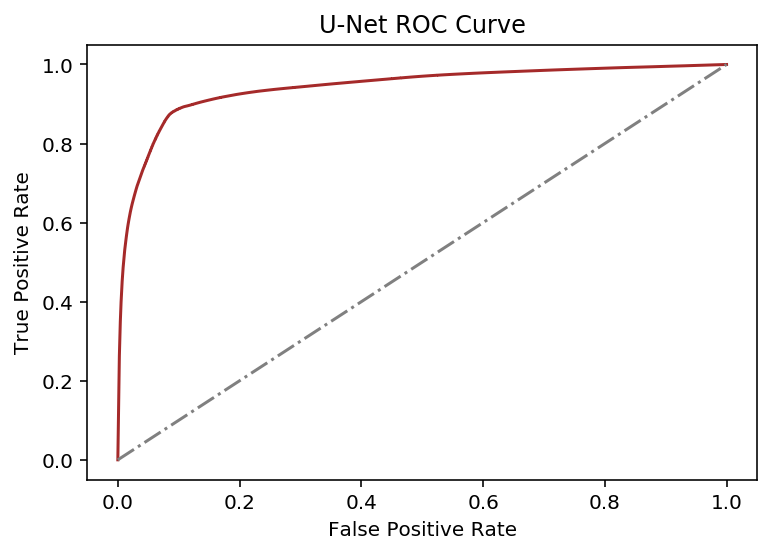

In [173]:
plt.plot(fpr, tpr, color = 'brown')
plt.plot([0,1],[0,1], '-.', color = 'grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('U-Net ROC Curve');
plt.show()

In [38]:
Y_test.shape

(257, 256, 256)

In [433]:
X_ex, Y_ex, index = next(example_generator)

('image_no:', 235, 'accuracy:', 0.990142822265625)


'fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16,10))\nax1.set_title("Post-Flood Image")\nax2.set_title("Identified Non-Flood Water Only")\nax3.set_title("Raw Model Likelihood")\nax1.imshow(fixed_X_pre);\nax2.imshow(fixed_X*(1.-pred[0,:,:,:]).astype(\'uint8\'))\nax3.imshow(probmap);'

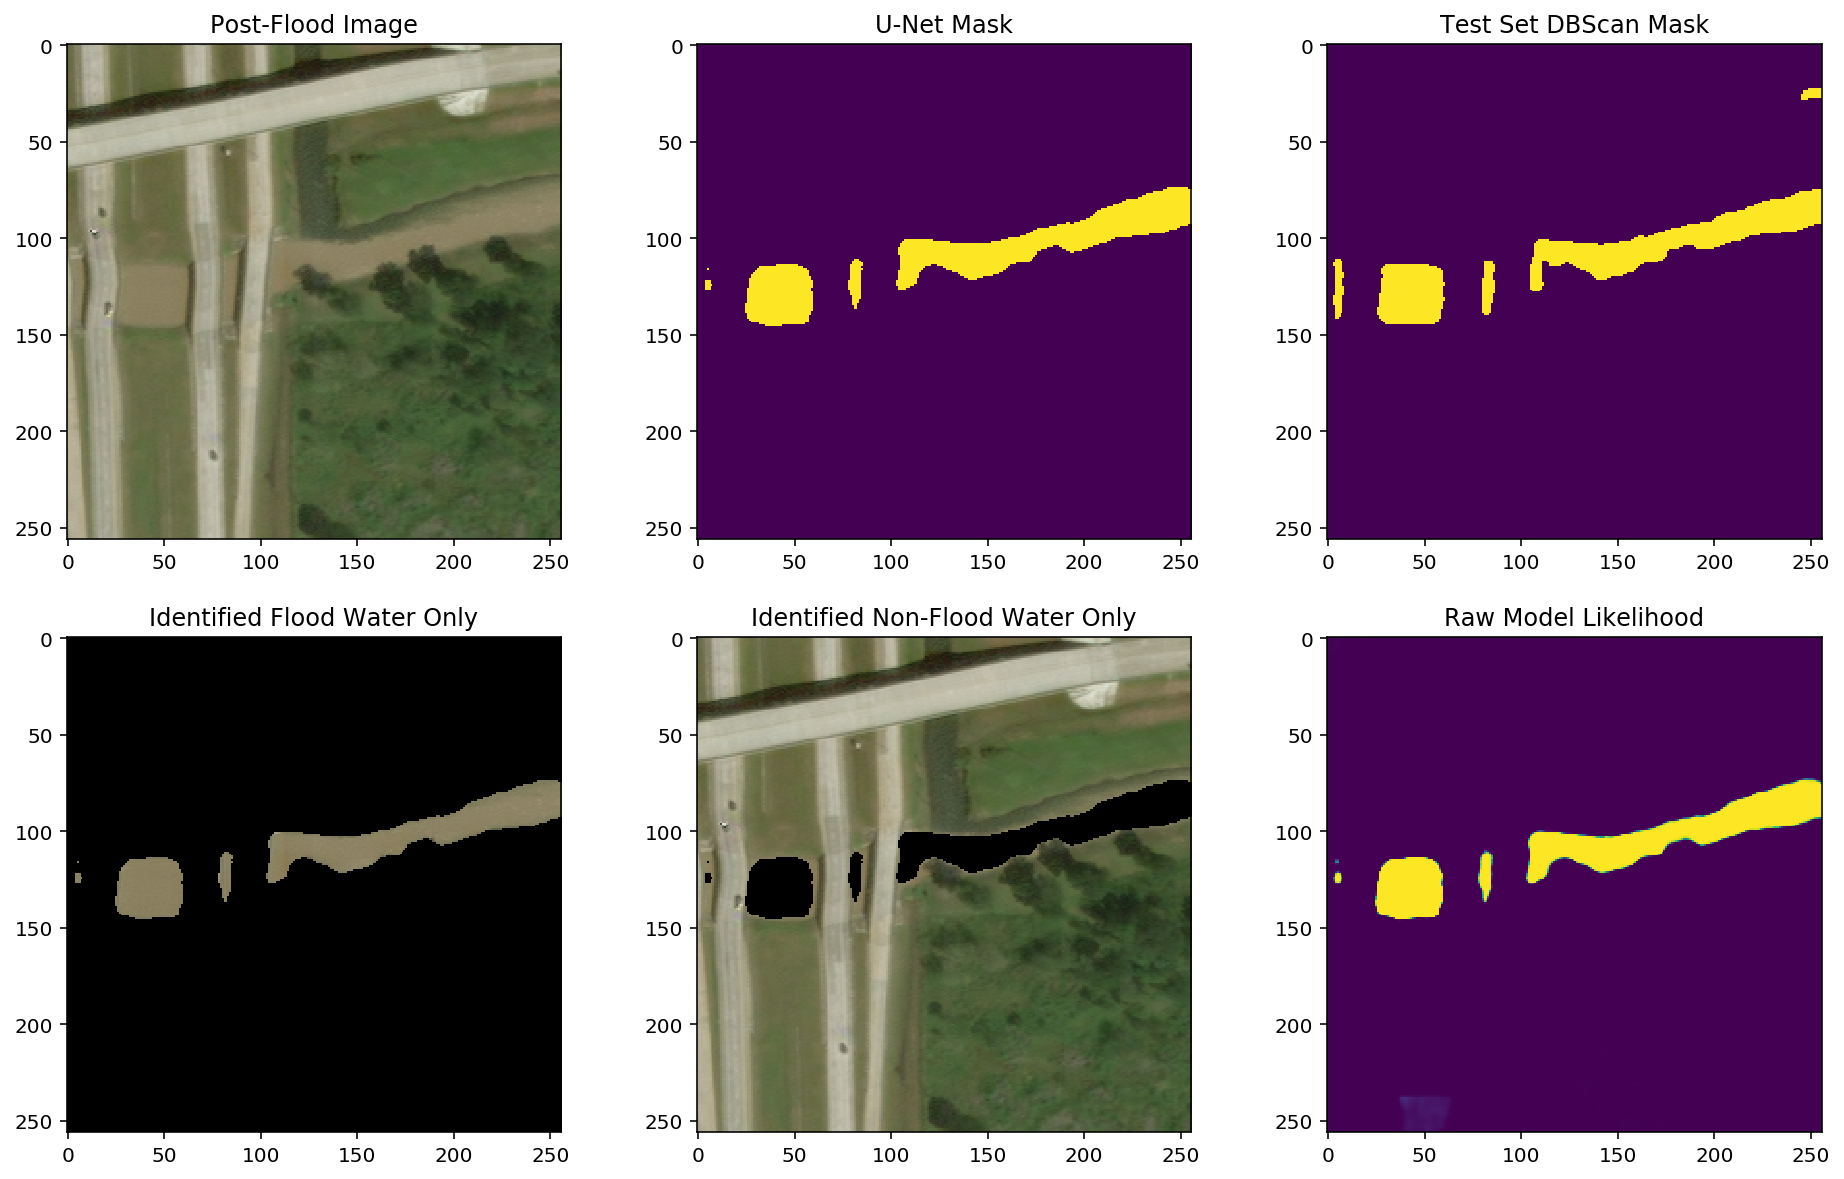

In [434]:
pred = model.predict(X_ex[None, ...]) > 0.5   #0.15
accuracy = (pred[0,:,:,0]==Y_ex).sum()*1.0/pred.size
print("image_no:", index, "accuracy:",accuracy)
#X_ex.shape,Y_ex.shape,pred[0,:,:,0].shape
fixed_X = (92.21524+92.21524*(X_ex[:,:,0:3]+1)).astype('uint8')
fixed_X_pre = (92.36813+92.36813*(X_ex[:,:,3:6]+1)).astype('uint8')
probmap = model.predict(X_ex[None, ...])[0,:,:,0]

fig, ((ax1,ax2,ax3),(ax11,ax12,ax13)) = plt.subplots(2, 3, figsize=(16,10))
ax1.set_title("Post-Flood Image")
ax2.set_title("U-Net Mask")
ax3.set_title("Test Set DBScan Mask")
ax1.imshow(fixed_X)
ax2.imshow(pred[0,:,:,0])
ax3.imshow(Y_ex);

#fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16,10))
ax11.set_title("Identified Flood Water Only")
ax12.set_title("Identified Non-Flood Water Only")
ax13.set_title("Raw Model Likelihood")
ax11.imshow(fixed_X*pred[0,:,:,:],)
ax12.imshow(fixed_X*(1.-pred[0,:,:,:]).astype('uint8'))
ax13.imshow(probmap);

"""fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16,10))
ax1.set_title("Post-Flood Image")
ax2.set_title("Identified Non-Flood Water Only")
ax3.set_title("Raw Model Likelihood")
ax1.imshow(fixed_X_pre);
ax2.imshow(fixed_X*(1.-pred[0,:,:,:]).astype('uint8'))
ax3.imshow(probmap);"""

In [269]:
Y_ex.sum()/Y_ex.shape[1]**2

0.785186767578125

In [ ]:
observed bad masks[7,]

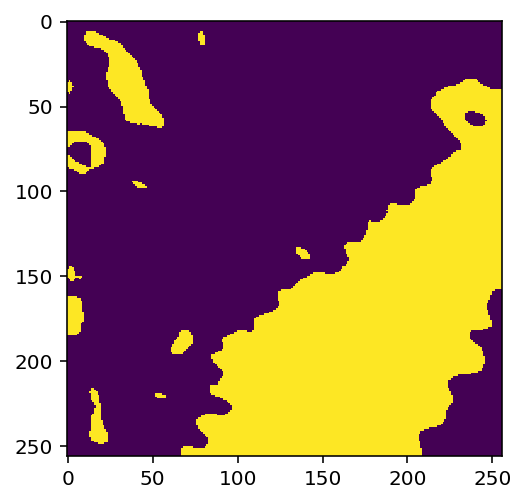

In [50]:
plt.imshow(pred[0,:,:,0]);

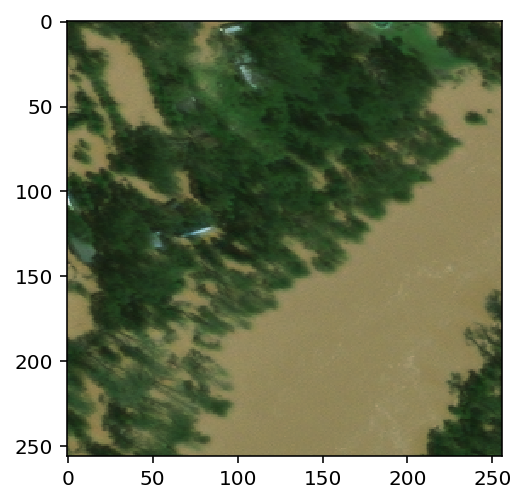

In [51]:
fixed_X = (92.21524+92.21524*(1+X_ex[:,:,0:3])).astype('uint8')
plt.imshow(fixed_X);

In [ ]:
probmap = model.predict(X_ex[None, ...])[0,:,:,0]
print(probmap.shape)
plt.imshow(probmap);

Now lets show a few examples.  Each row shows a target class.  Yellow areas are positive, and purple areas are negative.  At this point, you will begin to see that OSM data isn't always accurate.
**Top row**: Residential
**Middle row**: Forest
**Top row**: Water

In [ ]:
X_ex, Y_ex = next(example_generator)

In [ ]:
plot_example_class(X_ex, Y_ex, model)

In [ ]:
X_ex.shape,Y_ex.shape

#note from Alan
You'll notice that the validation loss is generally decreasing over all the training epochs, and then it eventually goes up a little and then plateaus at 0.0713, with a corresponding validation jaccard coefficient of 0.6682.  This is our final model, although if we want we can go back and grab previous states of the model.  They're all saved in the `checkpoints/` directory.

I should issue a word of caution at this point.  I was in a hurry to put this notebook up and I made a few mistakes in my data processing.  I already caught two whoppers that were totally messing up the training, and there might be more.

## View some output
Now I'll test out the model by testing it on a single image and looking at the ground truth against the model prediction.

Now lets show a few examples.  Each row shows a target class.  Yellow areas are positive, and purple areas are negative.  At this point, you will begin to see that OSM data isn't always accurate.
**Top row**: Residential
**Middle row**: Forest
**Top row**: Water

In [ ]:
#what would random chance predict?
per_flooded = Y_train.sum()/(len(Y_train)*256*256)
per_flooded

In [ ]:
#what would random chance predict?
per_flooded = Y_test.sum()/(len(Y_test)*256*256)
per_flooded